In [1]:
import sys
sys.argv=['']
sys.path.append("..")

In [2]:
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import random
import scipy
import torch
import torchtuples as tt

In [3]:
from models.encoders import *
from pycox.models import DeepHitSingle,CoxTime,CoxCC
from pycox.models.cox_time import MLPVanillaCoxTime
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv as skSurv
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc, brier_score, integrated_brier_score
from sklearn_pandas import DataFrameMapper
from lifelines import KaplanMeierFitter
from sklearn.utils import resample
from torchtuples.practical import MLPVanilla
from torchtuples import Model, optim
from torch.nn import functional as F
from utils.param_search import *
from utils.output_results import *

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', '-dt', default='0.2', type=str) #LungCancerExplorer, Metabric
parser.add_argument('--plot_mode', '-pm', default=True, action='store_true')
parser.add_argument('--name', '-n',type=str, default="DeepHit") #CoxTime, DeepHit, CoxCC, PseudoContinuous, PseudoDiscrete PseudoDiscreteAll PseudoContinuous PseudoKM,'PsdeudoOptim' 
parser.add_argument('--uncertainty', '-u',type=str, default="Bootstrap") #Bootstrap, MCDropout, DeepEnsemble, VAE, BMask
parser.add_argument('--filename', '-f',type=str, default="simdata_2")
parser.add_argument('--timepoints', '-tp',type=str, default="fixed")
config = parser.parse_args()

In [6]:
main =  "C:/Users/E_ROBLIN/Desktop/these/Code_these/simulation/"

In [11]:
dir_res = main + 'results/'+ config.dataset + "/"+config.uncertainty+"/"+ config.name+'/'+str(config.filename)+'/'
os.makedirs(dir_res, exist_ok=True)
dir_data = main + 'data'+'/'+config.dataset + "/"+str(config.filename)+"/"

# Data Preparation

The data is split into train and test sets beforehand. As the data is simulated, it is possible to output the true value of survival times: it is stored in the st_test file. 

In [12]:
df_train = pd.read_csv(dir_data+"sim_train.csv")
df_test = pd.read_csv(dir_data+"sim_test.csv")
st_test = pd.read_csv(dir_data+"st_test.csv").T
st_test.index = st_test.index.astype('float')

The simulated data is composed of continous variables (the X variables) and a binary variable (the Z variable). 

In [13]:
ContVar = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
CatVar = ['Z1']
AllVar = ContVar+CatVar+['yy', 'status','id']

The continuous variable are standardized. The yy variable corresponds to the survival time, the status is the censoring indicator (a value of 0 corresponds to censoring) and the id variable is the id of the patient.

In [14]:
standardize = [([col], StandardScaler()) for col in ContVar]
leave = [(col, None) for col in ['yy', 'status','id']+CatVar]
df_mapper = DataFrameMapper(standardize + leave, df_out=True) 

# Cross Validation and Hyperparameters Search

A simple 5-folds cross validation is implemented using the training set to determine the hyperparameters of the neural network models. The optuna package is used to perform the hyperparmeter search. The hyperparameter that are searched are the following:

| Hyperparameter | Values |
|----------|--------------|
| Activation function |  {tanh, relu} |
| Batch size |  {8,16,32,64,128} |
| Dropout rate |  [0.0,0.3] | 
|Layers | {1,2,3,4}|
|Learning rate|[1e-3, 1e-2]|
|Neurons|[4,128]|
|Optimizer|{adam, adam_amsgrad, RMSProp, SGDWR}|
|Pénalisation L2|[0,0.1]|
|Alpha (DeepHit)|[0,1]|
|Sigma(DeepHit)|{0.1,0.25,0.5,1,2.5,5,10,100}|
|Durations(DeepHit)|{10,50,100,200,400}|

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name = config.name, 
                            storage = 'sqlite:///'+dir_res+config.name+ '.db',
                            sampler=sampler, 
                            direction='minimize', 
                            load_if_exists=True)

study.optimize(lambda trial : objective_net(trial,
                                            df_train,
                                            df_mapper,
                                            dir_res,
                                            config), 
               n_trials=200)

print("Best trial:")
trial = study.best_trial
outer_loop = pd.DataFrame([trial.params])
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(study.trials_dataframe())

outer_loop.to_csv(dir_res + 'best_param.csv', sep = ';', index = False, header = True)
df_results = study.trials_dataframe()
df_results.to_csv(dir_res + 'trials_dataframe.csv', sep = ';', header = True)

# Uncertainty Measure using Bootstrap

We build the model using always the same hyperparameters that were selected by cross validaton. We sample with replacement data from the training set.  Then, the model is trained on this  bootstraped dataset. We repeat the sampling M times, obtaining M predictions per point of the test set. This is the method called [Bootstrap](https://www.jstor.org/stable/2958830).

We load the hyperparameters selected previously.

In [15]:
outer_loop = pd.read_csv(dir_res+'best_param.csv', sep = ';')
config.acti_func = outer_loop['activation'][0]
config.batch_size = outer_loop['batch_size'][0]
config.dr = outer_loop['dropout'][0]
config.layers = outer_loop['n_layers'][0]
config.lr  = outer_loop['learning_rate'][0]
config.neurons = outer_loop['neurons'][0]
config.optim = outer_loop['optimizer'][0]
config.pen_l2 = outer_loop['l2'][0]

if config.name=="DeepHit":
    config.alpha = outer_loop['alpha'][0] 
    config.sigma = outer_loop['sigma'][0]
    config.num_durations = outer_loop['num_durations'][0]
    labtrans = DeepHitSingle.label_transform(config.num_durations)
elif config.name=="CoxTime":
    labtrans = CoxTime.label_transform()
else:
    labtrans=""

We define the number of repetitions, M.

In [16]:
M=100

In [ ]:
if config.timepoints == "percentiles":
    kmf = KaplanMeierFitter()
    kmf.fit(np.array(df_train['yy']), np.array(df_train['status']))
    time_grid = np.array(kmf.percentile(np.linspace(0.9, 0.1, 9)).iloc[:,0])
elif config.timepoints == "fixed":
    if config.dataset == "Metabric":
        time_grid = [2,5]
    elif config.dataset == "LungCancerExplorer":
        time_grid = [24,60]
    else:
        time_grid = [0.5,1,2,3]

We compute the Concordance Index (C-index), the Oracle C-index, the Bias, the Oracle Bias, and the survival predictions for the model at the timepoints of the time grid previously defined.

In [20]:
CAll = pd.DataFrame()
COrAll = pd.DataFrame()
BsAll = pd.DataFrame()
BsOrAll = pd.DataFrame()
PredAll = []
measures = pd.DataFrame()

for j in range(M):
    print(j)
    
    #Bootstrap of the train set and split into validation and train set
    df_trainb = df_train.iloc[resample(df_train.index, replace=True, n_samples=len(df_train),random_state=j)]
    df_valb = df_trainb.sample(frac=0.2, random_state = j)
    df_trainb = df_trainb.drop(df_valb.index)

    df_trainb = df_mapper.fit_transform(df_trainb)
    df_valb = df_mapper.transform(df_valb).astype('float32')
    df_test = df_mapper.transform(df_test).astype('float32')

    x_train = np.array(df_trainb.drop(['yy','status','id'], axis=1)).astype('float32')
    x_val = np.array(df_valb.drop(['yy','status','id'], axis=1)).astype('float32')
    x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
    y_train = (df_trainb['yy'].values, df_trainb['status'].values)
    y_val = (df_valb['yy'].values, df_valb['status'].values)
    y_test = (df_test['yy'].values, df_test['status'].values)

    if labtrans !="":
        y_train = labtrans.fit_transform(*y_train)
        y_val = labtrans.transform(*y_val)

    val = tt.tuplefy(x_val, y_val)

    in_features = x_train.shape[1]
    model,callbacks = build_model_net(config,in_features,labtrans)

    log = model.fit(x_train, 
                y_train, 
                int(config.batch_size),
                epochs = 500, 
                callbacks = callbacks,
                verbose = False,
                val_data = val,
                shuffle=True)
    
    #Output of the survival probabilities
    if config.name in ["CoxCC","CoxTime"]:
        _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)
    elif config.name == "DeepHit":
         surv = model.interpolate(10).predict_surv_df(x_test)

    #Output of the evaluation measures on the test set at predifined time points
    data_train = skSurv.from_arrays(event=df_trainb['status'], time=df_trainb['yy'])
    data_test = skSurv.from_arrays(event=df_test['status'], time=df_test['yy'])
    CAll[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(surv,t)),t)[0] for t in time_grid]
    BsAll[j] = [brier_score(data_train, data_test, np.array(-determine_surv_prob(surv,t)),t)[1][0] for t in time_grid]
    preds = np.asarray([determine_surv_prob(surv,t) for t in time_grid])
    PredAll.append(preds)
    BsOrAll[j] = [brier_score(data_train, data_test, np.array(-determine_surv_prob(st_test,t)),t)[1][0] for t in time_grid]     
    COrAll[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(st_test,t)),t)[0] for t in time_grid]     

    del model 
    del log

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

For the coverage rate, the level of confidence is $\alpha = 0.95$.

In [ ]:
measures['C'] = CAll.mean(axis=1)
measures['C_Oracle'] = COrAll.mean(axis=1)
measures['BS'] = BsAll.mean(axis=1)
measures['BS_Oracle'] = BsOrAll.mean(axis=1)

res_all = np.empty((M,len(time_grid)))
for m in range(M):
    res_all[m,] = [np.mean(PredAll[m][t]) for t in range(len(time_grid))]

cr = []
BNAll = pd.DataFrame()
alpha = 0.95
for t in range (len(time_grid)):
    res_time = pd.DataFrame([PredAll[l][t] for l in range(M)]).T
    cr.append(output_cr(res_time,st_test,time_grid[t],0.95))
    BNAll[str(time_grid[t])] = np.mean(pd.DataFrame([PredAll[l][t]-determine_surv_prob(st_test,time_grid[t]) for l in range(M)]).T)
measures['Bias_id'] = np.array(BNAll.mean())
measures['Coverage'] = cr
measures['Time'] = time_grid
measures.to_csv(dir_res+'measures_'+config.name+'.csv', sep = ';', header = True, index=True)

In [ ]:
measures

In [ ]:
# CAll = pd.DataFrame()
# COrAll = pd.DataFrame()
# BsAll = pd.DataFrame()
# BsOrAll = pd.DataFrame()
# measures = pd.DataFrame()

# PredAll1 = pd.DataFrame()
# ts_pred  = pd.DataFrame()
# ts_c  = np.zeros(M)
# stat = []

# df_train = pd.read_csv(dir_data+"sim_train.csv")
# df_test = pd.read_csv(dir_data+"sim_test.csv")


# df_train = df_train.iloc[resample(df_train.index, replace=True, n_samples=len(df_train),random_state=j)]
# df_val = df_train.sample(frac=0.2, random_state = j)
# df_train = df_train.drop(df_val.index)

# df_train = df_mapper.fit_transform(df_train)
# df_val = df_mapper.transform(df_val).astype('float32')
# df_test = df_mapper.transform(df_test).astype('float32')

# x_train = np.array(df_train.drop(['yy','status','id'], axis=1)).astype('float32')
# x_val = np.array(df_val.drop(['yy','status','id'], axis=1)).astype('float32')
# x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
# y_train = (df_train['yy'].values, df_train['status'].values)
# y_val = (df_val['yy'].values, df_val['status'].values)
# y_test = (df_test['yy'].values, df_test['status'].values)

# if labtrans !="":
#     y_train = labtrans.fit_transform(*y_train)
#     y_val = labtrans.transform(*y_val)

# val = tt.tuplefy(x_val, y_val)

# in_features = x_train.shape[1]
# model,callbacks = build_model_net(config,in_features,labtrans)

# log = model.fit(x_train, 
#             y_train, 
#             int(config.batch_size),
#             epochs = 500, 
#             callbacks = callbacks,
#             verbose = False,
#             val_data = val,
#             shuffle=True)
# log.plot()
# if config.name in ["CoxCC","CoxTime"]:
#     _ = model.compute_baseline_hazards()
#     surv = model.predict_surv_df(np.array(x_test))
# elif config.name == "DeepHit":
#     surv = model.interpolate(10).predict_surv_df(x_test)

# data_train = skSurv.from_arrays(event=df_train['status'], time=df_train['yy'])
# data_test = skSurv.from_arrays(event=df_test['status'], time=df_test['yy'])
# C1 = concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(st_test,1)),1)[0]   

0
[0.7263573647695516]
0
1
2
3
4
5
6
7
8
9
1
[0.7263573647695516, 0.7273816603904268]
0
1
2
3
4
5
6
7
8
9
2
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751]
0
1
2
3
4
5
6
7
8
9
3
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912]
0
1
2
3
4
5
6
7
8
9
4
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798]
0
1
2
3
4
5
6
7
8
9
5
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 0.7260447352488659]
0
1
2
3
4
5
6
7
8
9
6
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 0.7260447352488659, 0.7258066191037287]
0
1
2
3
4
5
6
7
8
9
7
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 0.7260447352488659, 0.7258066191037287, 0.7262545979154962]
0
1
2
3
4
5
6
7
8
9
8
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.72678756740

C:\Users\E_ROBLIN\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 0.7260447352488659, 0.7258066191037287, 0.7262545979154962, 0.7260315066829175, 0.72718986848145, 0.7255482814198145, 0.7260471491035302, 0.7274167281816586, 0.7288739308641312, 0.725605207955076, 0.7245189165129006, 0.7264864810249565, 0.727232215913894, 0.7264386107815006, 0.7260014020781208, 0.7260287030253509]
0
1
2
3
4
5
6
7
8
9
21
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 0.7260447352488659, 0.7258066191037287, 0.7262545979154962, 0.7260315066829175, 0.72718986848145, 0.7255482814198145, 0.7260471491035302, 0.7274167281816586, 0.7288739308641312, 0.725605207955076, 0.7245189165129006, 0.7264864810249565, 0.727232215913894, 0.7264386107815006, 0.7260014020781208, 0.7260287030253509, 0.725565470252561]
0
1
2
3
4
5
6
7
8
9
22
[0.7263573647695516, 0.7273816603904268, 0.7258752346810751, 0.7268381302355912, 0.7267875674052798, 

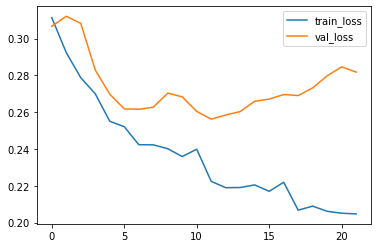

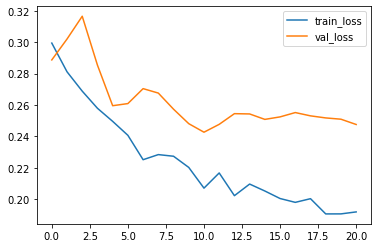

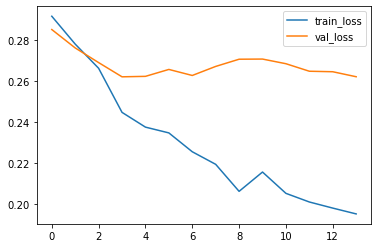

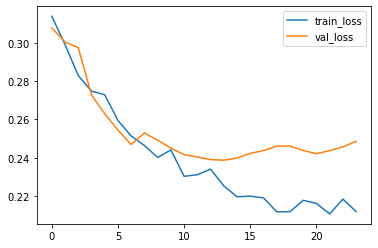

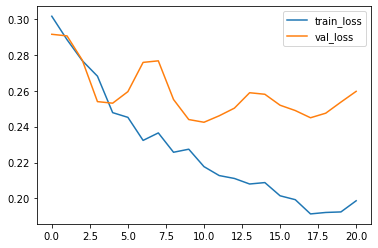

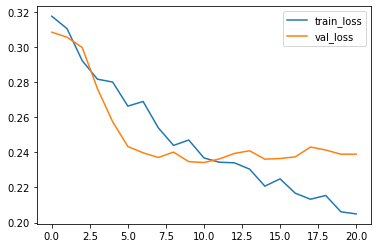

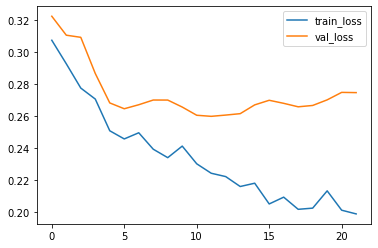

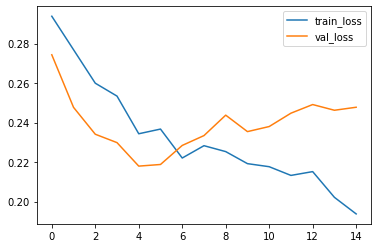

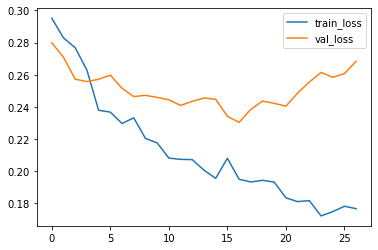

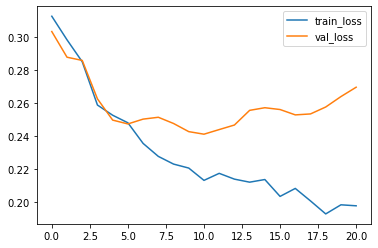

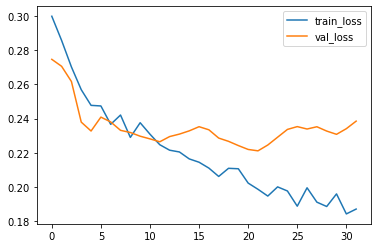

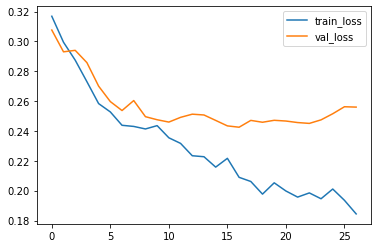

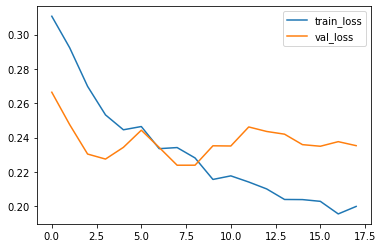

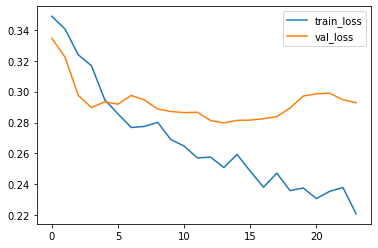

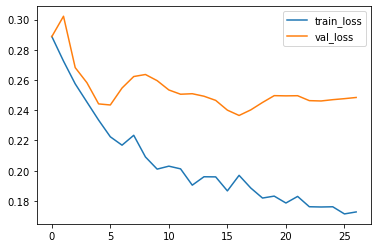

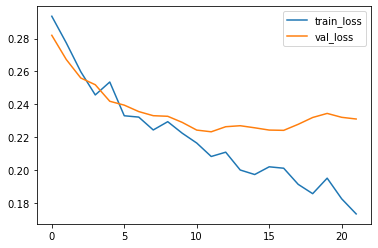

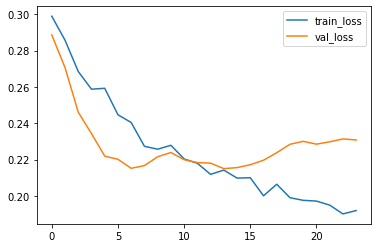

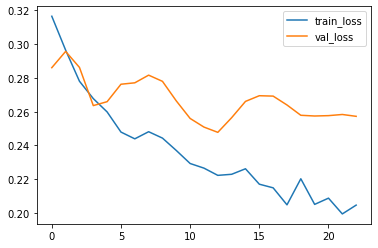

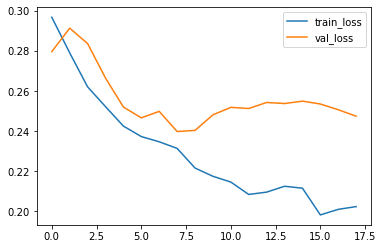

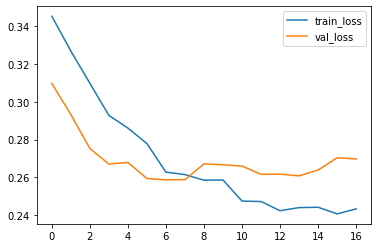

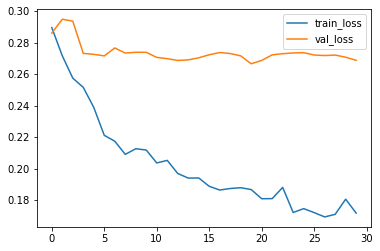

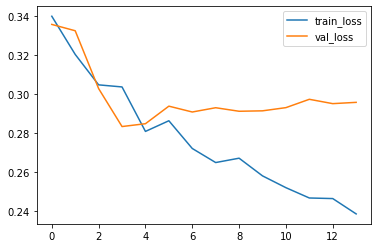

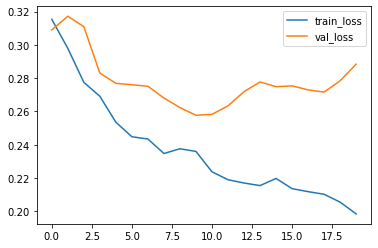

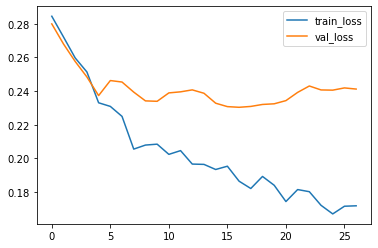

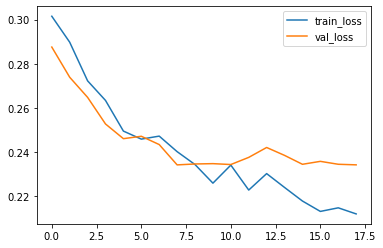

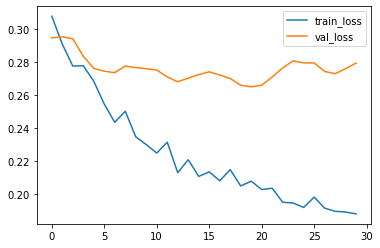

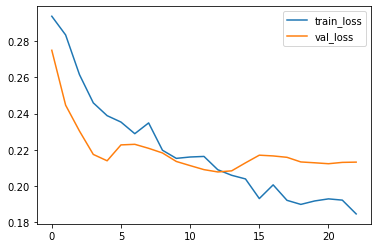

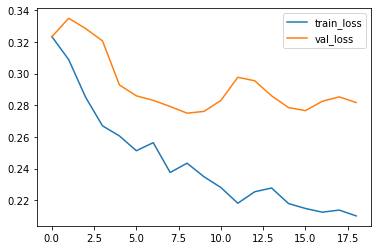

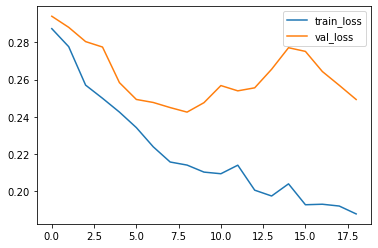

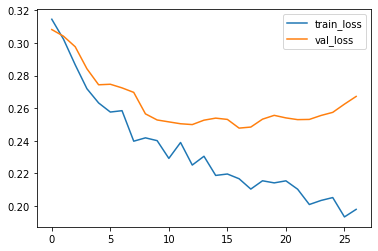

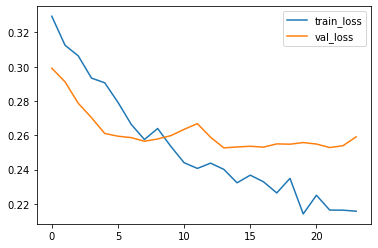

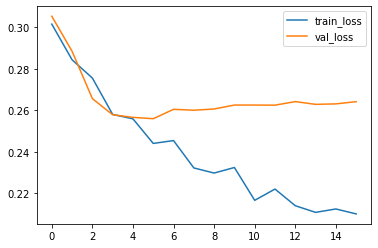

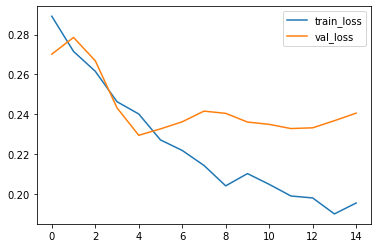

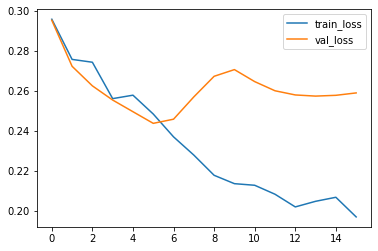

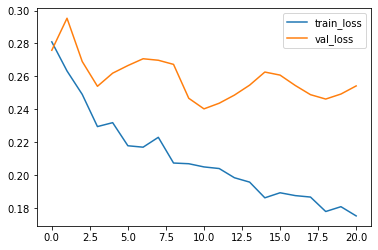

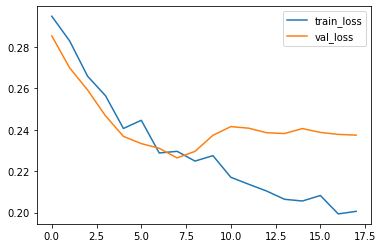

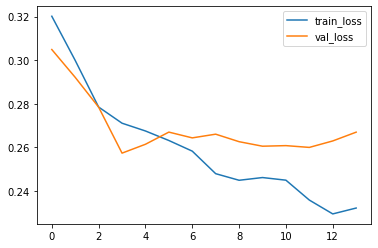

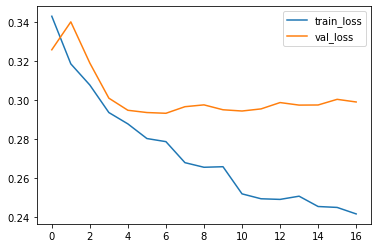

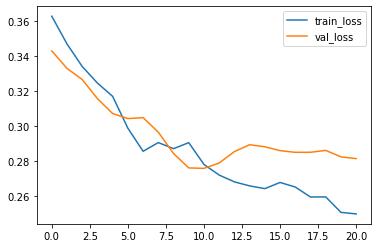

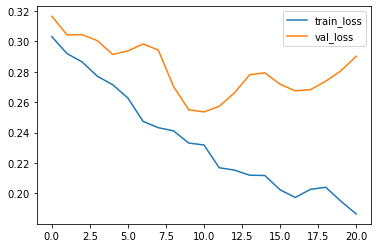

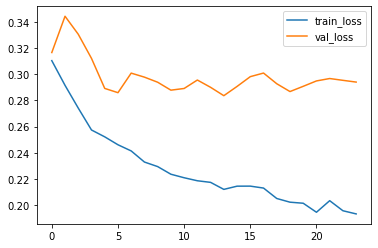

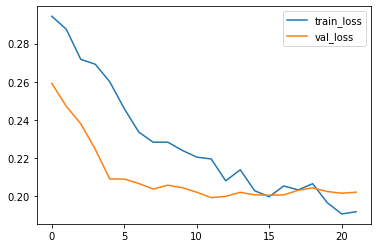

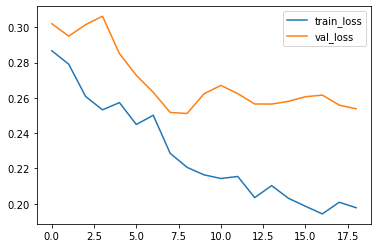

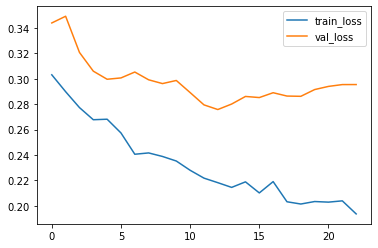

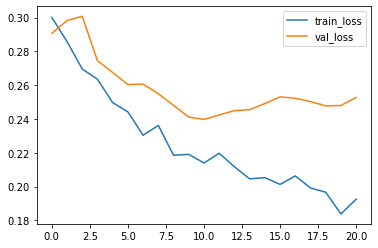

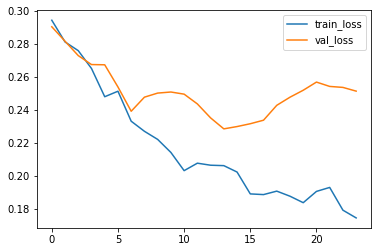

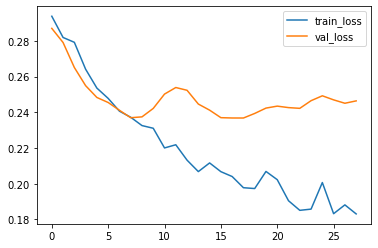

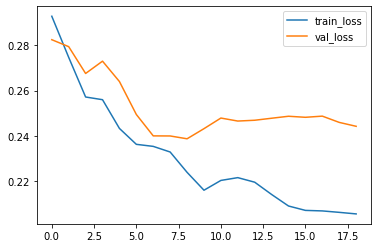

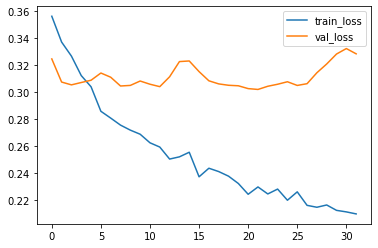

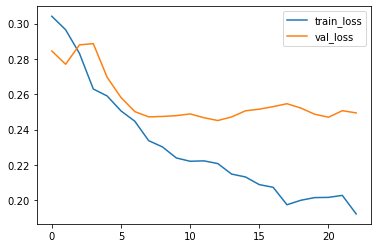

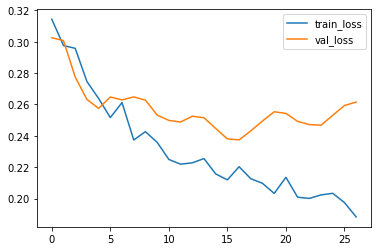

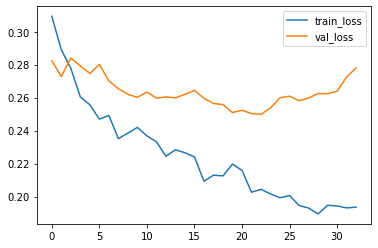

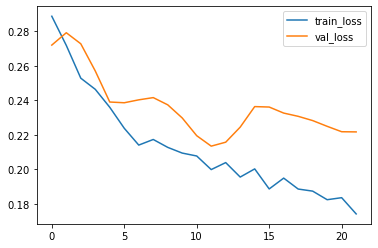

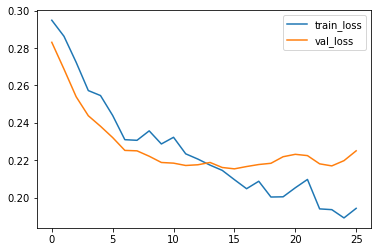

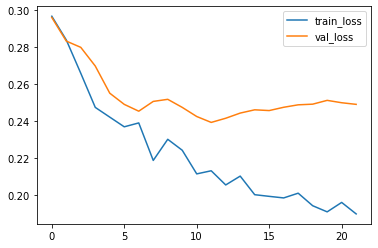

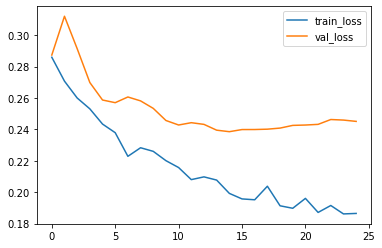

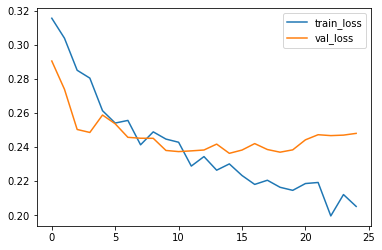

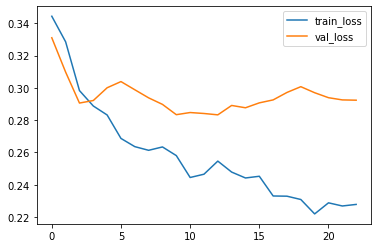

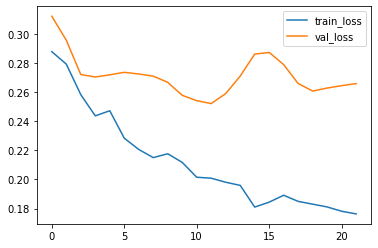

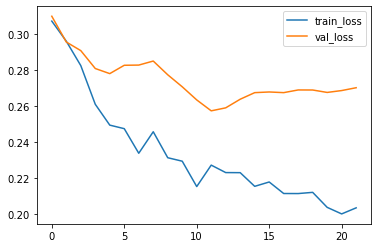

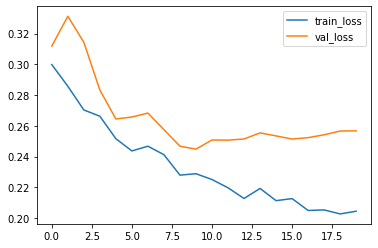

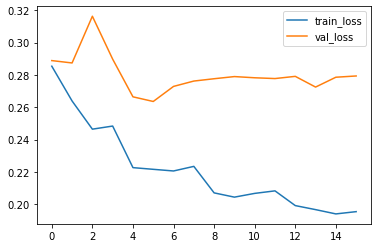

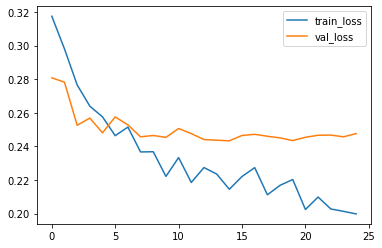

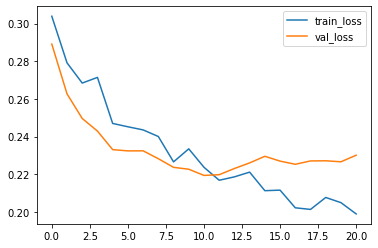

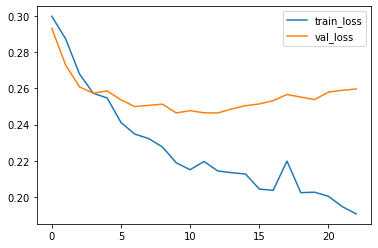

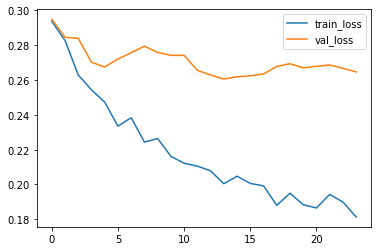

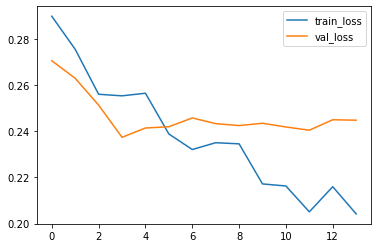

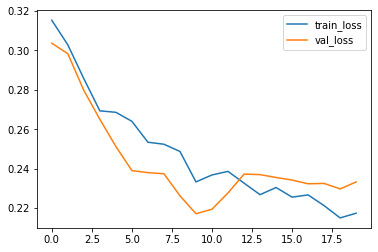

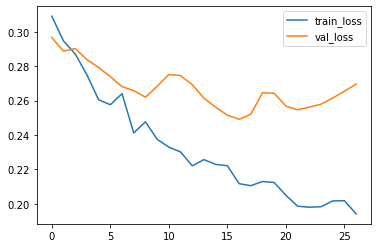

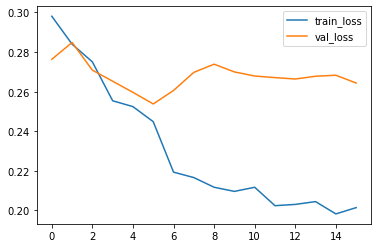

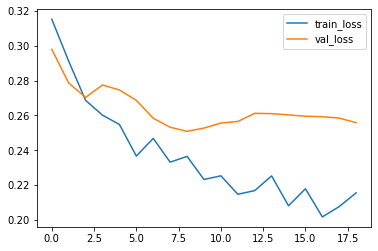

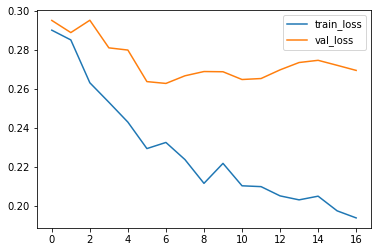

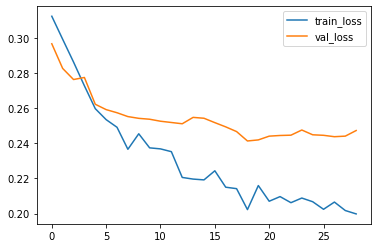

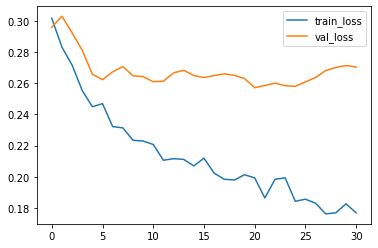

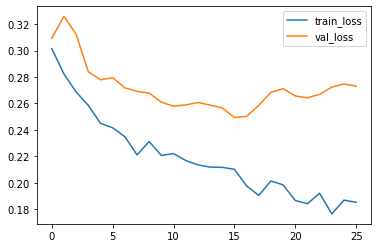

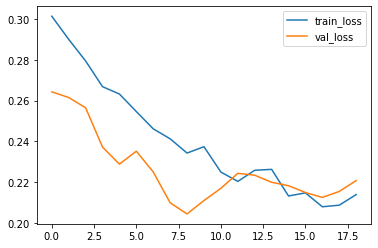

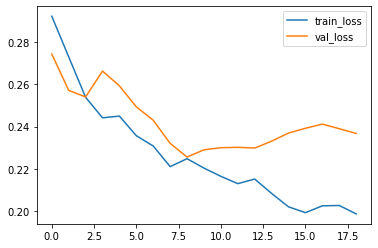

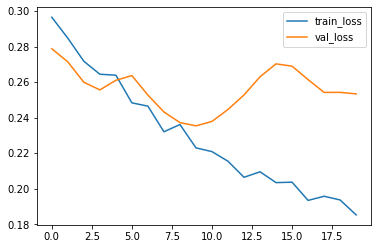

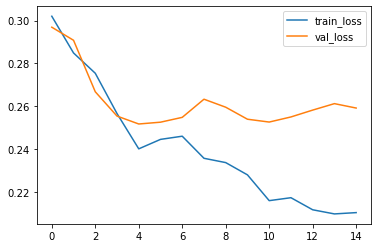

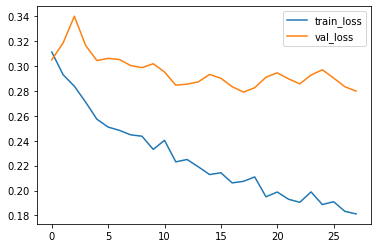

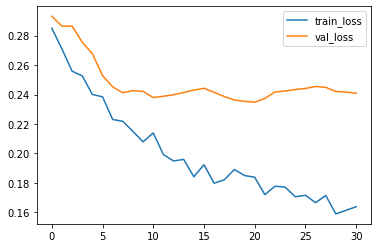

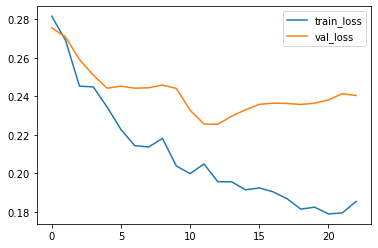

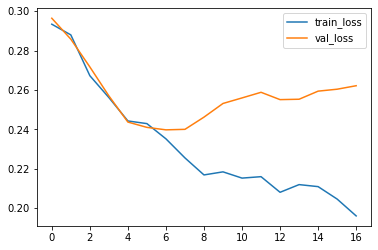

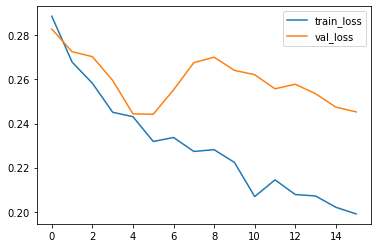

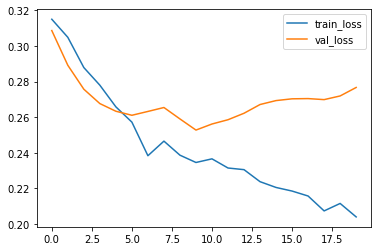

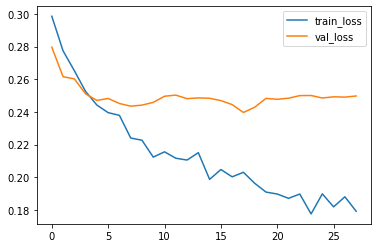

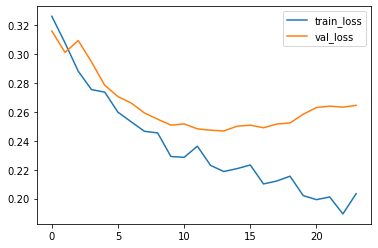

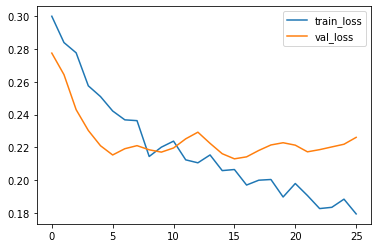

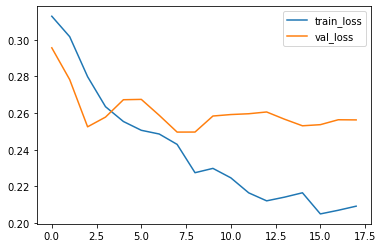

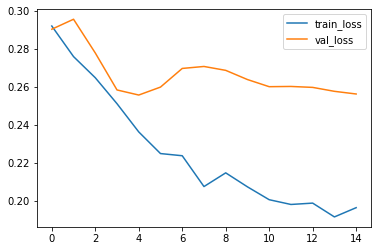

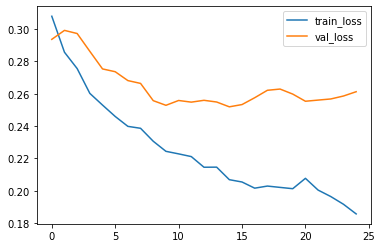

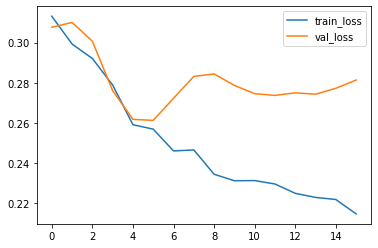

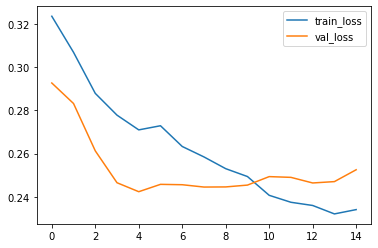

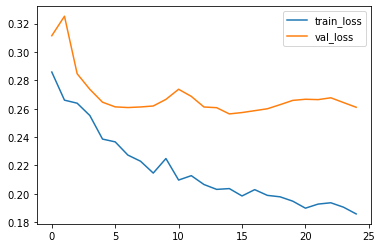

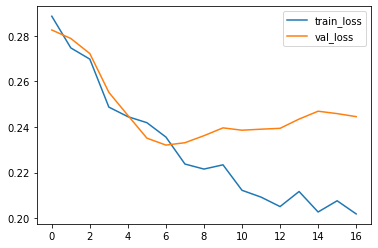

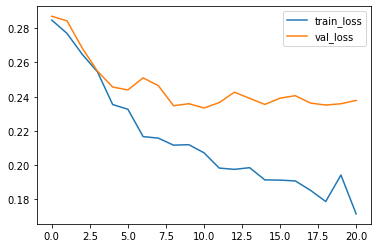

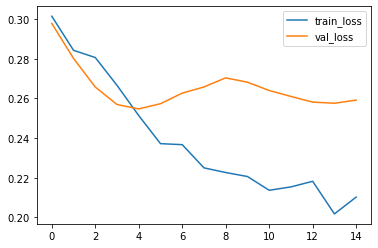

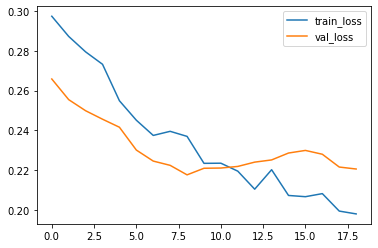

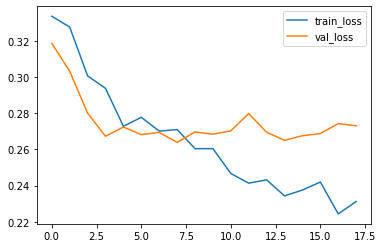

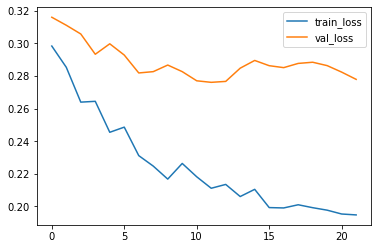

In [24]:
# for j in range(M):
#     df_train = pd.read_csv(dir_data+"sim_train.csv")
#     df_test = pd.read_csv(dir_data+"sim_test.csv")
#     print(j)
#     df_trainb = df_train.iloc[resample(df_train.index, replace=True, n_samples=len(df_train),random_state=j)]
#     df_valb = df_trainb.sample(frac=0.2, random_state = j)
#     df_trainb = df_trainb.drop(df_valb.index)

#     df_trainb = df_mapper.fit_transform(df_trainb)
#     df_valb = df_mapper.transform(df_valb).astype('float32')
#     df_test = df_mapper.transform(df_test).astype('float32')

#     x_train = np.array(df_trainb.drop(['yy','status','id'], axis=1)).astype('float32')
#     x_val = np.array(df_valb.drop(['yy','status','id'], axis=1)).astype('float32')
#     x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
#     y_train = (df_trainb['yy'].values, df_trainb['status'].values)
#     y_val = (df_valb['yy'].values, df_valb['status'].values)
#     y_test = (df_test['yy'].values, df_test['status'].values)

#     if labtrans !="":
#         y_train = labtrans.fit_transform(*y_train)
#         y_val = labtrans.transform(*y_val)

#     val = tt.tuplefy(x_val, y_val)

#     in_features = x_train.shape[1]
#     model,callbacks = build_model_net(config,in_features,labtrans)

#     log = model.fit(x_train, 
#                 y_train, 
#                 int(config.batch_size),
#                 epochs = 500, 
#                 callbacks = callbacks,
#                 verbose = False,
#                 val_data = val,
#                 shuffle=True)
#     log.plot()
#     if config.name in ["CoxCC","CoxTime"]:
#         _ = model.compute_baseline_hazards()
#         surv = model.predict_surv_df(np.array(x_test))
#     elif config.name == "DeepHit":
#         surv = model.interpolate(10).predict_surv_df(x_test)

#     data_train = skSurv.from_arrays(event=df_trainb['status'], time=df_trainb['yy'])
#     data_test = skSurv.from_arrays(event=df_test['status'], time=df_test['yy'])
#     CAll[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(surv,t)),t)[0] for t in time_grid]
#     #BsAll[j] = [brier_score(data_train, data_test, np.array(-determine_surv_prob(surv,t)),t)[1][0] for t in time_grid]
#     preds = np.asarray([determine_surv_prob(surv,t) for t in time_grid])
#     PredAll.append(preds)
#     PredAll1[j] = np.asarray(determine_surv_prob(surv,0.5))
#     CAll1 = concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(st_test,1)),1)[0]
#     stat.append(CAll1)
#     print(stat)
#     COrAll[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(st_test,t)),t)[0] for t in time_grid]     
#     del model
#     del log

#     df_trainb.reset_index(inplace=True,drop=True)
#     m=10
#     PredAll1b = []
#     resample_c = np.empty(m)
#     for k in range(m):
#         print(k)
#         df_trainbb = df_trainb.iloc[resample(df_trainb.index, replace=True, n_samples=len(df_trainb),random_state=k)]
#         df_valbb = df_trainbb.sample(frac=0.2, random_state = j)
#         df_trainbb = df_trainbb.drop(df_valbb.index)

#         x_train = np.array(df_trainbb.drop(['yy','status','id'], axis=1)).astype('float32')
#         x_val = np.array(df_valbb.drop(['yy','status','id'], axis=1)).astype('float32')
#         x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
#         y_train = (df_trainbb['yy'].values, df_trainbb['status'].values)
#         y_val = (df_valbb['yy'].values, df_valbb['status'].values)
#         y_test = (df_test['yy'].values, df_test['status'].values)

#         if labtrans !="":
#             y_train = labtrans.fit_transform(*y_train)
#             y_val = labtrans.transform(*y_val)

#         val = tt.tuplefy(x_val, y_val)

#         in_features = x_train.shape[1]
#         model,callbacks = build_model_net(config,in_features,labtrans)

#         log = model.fit(x_train, 
#                     y_train, 
#                     int(config.batch_size),
#                     epochs = 500, 
#                     callbacks = callbacks,
#                     verbose = False,
#                     val_data = val,
#                     shuffle=True)
#         if config.name in ["CoxCC","CoxTime"]:
#             _ = model.compute_baseline_hazards()
#         surv = model.predict_surv_df(np.array(x_test))
#         PredAll1b.append(np.asarray(determine_surv_prob(surv,1)))
#         data_train = skSurv.from_arrays(event=df_trainbb['status'], time=df_trainbb['yy'])
#         resample_c[k] = concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(surv,1)),1)[0] 

#     sum_surv = np.sum(pd.DataFrame(PredAll1b)-pd.DataFrame([list(PredAll1[j])]*m),axis=0)
#     ts_pred[j] = np.array(sum_surv/np.std(PredAll1b,axis=0))
#     ts_c[j] = np.sum(resample_c- CAll1) / np.std(resample_c)

In [ ]:
# s_c = np.std(resample_c)
# ts_co = np.sort(ts_c)

In [ ]:
# p1,p2 = np.percentile(s_c*ts_co , (2.5, 97.5))

In [25]:
# ts_co = np.sort(stat)
# p1,p2 = np.percentile(
# ts_co , (2.5, 97.5))

In [ ]:
# ci_high = C1 -(s_c*p1)
# ci_low = C1 - (s_c*p2)

In [ ]:
# s = np.std(PredAll1,axis=1)
# ts = np.sort(ts)

In [ ]:
# np.percentile(np.sort(pd.DataFrame(pd.DataFrame([list(s)]*M).T.values*ts.values).loc[0]),(2.5, 97.5))

In [ ]:
# for i in range(1,101):
#     print(i)
#     config.filename = "simdata_"+str(i)
#     dir_res = main+'results/'+ config.dataset + "/"+config.uncertainty+"/"+ config.name+'/'+config.filename+"/"
#     dir_data = main+'data/' + config.dataset + "/"+config.filename+"/"

#     #Import each simulation dataset and results
#     df_train = pd.read_csv(dir_data+"sim_train.csv")
#     df_test = pd.read_csv(dir_data+"sim_test.csv")
#     st_test = pd.read_csv(dir_data+"st_test.csv").T
#     st_test.index = st_test.index.astype('float')
#     outer_loop = pd.read_csv(dir_res+'best_param_'+config.name+'.csv', sep = ';')
    
#     c_all = pd.DataFrame()
#     bs_all = pd.DataFrame()
#     bs2_all = pd.DataFrame()
#     c_oracle_all = pd.DataFrame()
#     bs_oracle_all = pd.DataFrame()
#     preds_all = []
#     measures = pd.DataFrame()
#     #Bootstrap on each simulation dataset 
#     for j in range(1,101):
#         print(j)
#         if config.uncertainty == "Bootstrap":
#             df_trainb = df_train.iloc[resample(df_train.index, replace=True, n_samples=len(df_train),random_state=j)]
#         if config.name in ['PseudoDiscrete','PseudoOptim']:
#             y = pd.read_csv(dir_data+config.name+".csv")
  
#         df_val = df_trainb.sample(frac=0.2)
#         df_trainb = df_trainb.drop(df_val.index)

#         col_list = list(df_train.columns)
#         cols_standardize = [e for e in col_list if e not in ['yy', 'status','Z1','id']]
#         standardize = [([col], StandardScaler()) for col in cols_standardize]
#         leave = [(col, None) for col in ['yy', 'status','Z1','id']]
#         df_mapper = DataFrameMapper(standardize + leave, df_out=True) 
        
#         df_trainb = df_mapper.fit_transform(df_trainb)
#         df_val = df_mapper.transform(df_val).astype('float32')
#         df_test = df_mapper.transform(df_test).astype('float32')
#         if config.name=="DeepHit":
#             num_durations = 1000
#             labtrans = DeepHitSingle.label_transform(num_durations)
#         elif config.name=="CoxTime":
#             labtrans = CoxTime.label_transform()
#         else:
#             labtrans=""

#         if labtrans !="":
#             x_train = np.array(df_trainb.drop(['yy','status','id'], axis=1)).astype('float32')
#             x_val = np.array(df_val.drop(['yy','status','id'], axis=1)).astype('float32')
#             x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
#             y_train = (df_trainb['yy'].values, df_trainb['status'].values)
#             y_val = (df_val['yy'].values, df_val['status'].values)
#             y_test = (df_test['yy'].values, df_test['status'].values)
#             y_train = labtrans.fit_transform(*y_train)
#             y_val = labtrans.transform(*y_val)
#             y_test = labtrans.transform(*y_test)
#             val = tt.tuplefy(x_val, y_val)
#         elif config.name in ['PseudoDiscrete','PseudoOptim']:
#             pseudo_train, pseudo_val = y[y['id'].isin(list(np.unique(df_trainb[['id']])))], y[y['id'].isin(list(np.unique(df_val[['id']])))]
#             x_train, y_train,n_times = prepare_pseudobs(df_trainb,pseudo_train, config)
#             x_val, y_val, n_times = prepare_pseudobs(df_val,pseudo_val, config)
#             val = (x_val, y_val)
#         else:
#             x_train = np.array(df_trainb.drop(['yy','status','id'], axis=1)).astype('float32')
#             x_val = np.array(df_val.drop(['yy','status','id'], axis=1)).astype('float32')
#             x_test = np.array(df_test.drop(['yy','status','id'], axis=1)).astype('float32')
#             y_train = (df_trainb['yy'].values, df_trainb['status'].values)
#             y_val = (df_val['yy'].values, df_val['status'].values)
#             val = tt.tuplefy(x_val, y_val)
#             val = val.repeat(10).cat()

#         in_features = x_train.shape[1]
#         config.acti_func = outer_loop['activation'][0]
#         config.batch_size = outer_loop['batch_size'][0]
#         config.dr = outer_loop['dropout'][0]
#         config.layers = outer_loop['n_layers'][0]
#         config.lr  = outer_loop['learning_rate'][0]
#         config.neurons = outer_loop['neurons'][0]
#         config.optim = outer_loop['optimizer'][0]
#         config.pen_l2 = outer_loop['l2'][0]


#         model,callbacks = build_model_net(config,
#                                   in_features,
#                                   labtrans)
#         log = model.fit(x_train, 
#                     y_train, 
#                     int(outer_loop['batch_size'][0]),
#                     epochs = 500, 
#                     callbacks = callbacks,
#                     verbose = False,
#                     val_data = val)
#         if config.name in ["CoxCC","CoxTime"]:
#             _ = model.compute_baseline_hazards()
#             surv = model.predict_surv_df(np.array(x_test))
#         else:
#             surv =model.interpolate(10).predict_surv_df(x_test)


#         data_train = skSurv.from_arrays(event=df_trainb['status'], time=df_trainb['yy'])
#         data_test = skSurv.from_arrays(event=df_test['status'], time=df_test['yy'])
#         ev = EvalSurv(surv, np.array(df_test['yy']), np.array(df_test['status']), censor_surv='km')

#         kmf = KaplanMeierFitter()
#         kmf.fit(np.array(df_trainb['yy']), np.array(df_trainb['status']))
#         med_time = kmf.median_survival_time_
#         time_grid = np.array(kmf.percentile(np.linspace(0.9, 0.1, 9)).iloc[:,0])
#         c_all[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(surv,t)),t)[0] for t in time_grid]
#         preds = np.asarray([determine_surv_prob(surv,t) for t in time_grid])
#         preds_all.append(preds)
#         c_oracle_all[j] = [concordance_index_ipcw(data_train, data_test, np.array(-determine_surv_prob(st_test,t)),t)[0] for t in time_grid]  

#     measures['C'] = c_all.mean(axis=1)
#     measures['Brier Score'] = bs_all.mean(axis=1)
#     measures['C_Oracle'] = c_oracle_all.mean(axis=1)

#     res_all = np.empty((100,len(time_grid)))
#     for m in range(100):
#         for n in range(len(time_grid)):
#             res_all[m,n] = np.mean(preds_all[m][n])

#     bias = np.mean(pd.DataFrame(res_all)) - np.linspace(0.9, 0.1, 9)
#     sqrt_mse = np.sqrt(bias**2 + np.var(pd.DataFrame(res_all)))
#     measures['Sqrt_mse'] = sqrt_mse
#     measures['Bias_mean'] = bias

#     cr = []
#     bias_n_all = pd.DataFrame()
#     bias_n = pd.DataFrame()
#     alpha = 0.95
#     for k in range (len(time_grid)):
#         res_time_boot = pd.DataFrame()
#         for l in range(100):
#             res_time_boot[l] = preds_all[l][k]
#             bias_n[l] = preds_all[l][k]-determine_surv_prob(st_test,time_grid[k])
#         cr.append(output_cr(res_time_boot,st_test,time_grid[k],0.95))
#         bias_n_all[str(time_grid[k])] = np.mean(bias_n)
#     bias_id = np.array(bias_n_all.mean())
#     sqrt_mse_id = np.sqrt(bias_id**2 + np.var(pd.DataFrame(res_all)))
#     measures['Bias_id'] = np.array(bias_n_all.mean())
#     measures['Sqrt_mse_id'] = sqrt_mse_id
#     measures['Coverage'] = cr
#     measures['Time'] = time_grid
#     measures.to_csv(dir_res+'measures_'+config.name+'.csv', sep = ';', header = True, index=True)